# 5 在未标记的数据上进行训练

## 5.1 评估生成文本模型

![1718851702204](../image/从零开始构建LLM/1718851702204.png)



### 5.1.1 使用GPT模型生成文本

In [40]:
import os
import numpy as np
import torch
import torch.nn as nn
import tiktoken
import matplotlib.pyplot as plt

from scripts.GPTmodel import GPTModel
from scripts.scripts import generate_text_simple

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768

与之前的进行对比，context_length减少到256（之前为1024），这一改变减少了计算需求，使得能够在桌面版计算机(laptop desktop)上运行。
在之后的训练中，将其更新回1024，以便于加载预训练模型。

三步生成文本的过程：
1. tokenizer将输入文本转换为一系列token IDs
2. 模型将token IDs转换为对应的logits，logits表示每个token在字典中可能的分布状况
3. 将logits转换为token IDs，tokenizer再进行解码，生成文本

![1718853446792](../image/从零开始构建LLM/1718853446792.png)

In [3]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    decoded = tokenizer.decode(token_ids.squeeze(0).tolist())
    return decoded

In [4]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

encoded = text_to_token_ids(start_context, tokenizer)
print(">> encoded:", encoded)

token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=10, context_size=GPT_CONFIG_124M['context_length'])

decoded_text = token_ids_to_text(token_ids, tokenizer)
print(">> decoded_text:", decoded_text)

>> encoded: tensor([[6109, 3626, 6100,  345]])
>> decoded_text: Every effort moves youvationably sixth WWE Naturally fortune score honoured Dallasextreme


### 5.1.2 计算文本生成的损失

![1718854323771](../image/从零开始构建LLM/1718854323771.png)

In [5]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(">> probas: ", probas)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(">> token_ids: ", token_ids)

print(">> target batch: ", token_ids_to_text(targets[0], tokenizer))
print(">> predicted batch: ", token_ids_to_text(token_ids[0].flatten(), tokenizer))

>> probas:  tensor([[[1.8572e-05, 1.2867e-05, 1.0348e-05,  ..., 1.3664e-05,
          9.2556e-06, 2.2009e-05],
         [2.3067e-05, 1.8083e-05, 1.2638e-05,  ..., 1.4849e-05,
          7.1591e-06, 3.0771e-05],
         [2.0588e-05, 1.2996e-05, 1.5177e-05,  ..., 1.8670e-05,
          2.3397e-05, 7.5619e-06]],

        [[5.0293e-05, 4.9116e-06, 2.7594e-05,  ..., 1.7464e-05,
          2.0475e-05, 4.7268e-05],
         [2.0319e-05, 6.0855e-06, 1.3149e-05,  ..., 3.8269e-05,
          7.7382e-06, 4.4218e-05],
         [1.8622e-05, 1.7539e-05, 3.4765e-05,  ..., 2.4357e-05,
          2.1983e-05, 1.0918e-05]]])
>> token_ids:  tensor([[[33635],
         [28624],
         [34407]],

        [[11896],
         [38371],
         [  115]]])
>> target batch:   effort moves you
>> predicted batch:  ESEaples perk


由于还未被训练，因此产生的为随机文本。
训练过程是不断减小目标与预测值之间的“距离”。

![1718868480909](../image/从零开始构建LLM/1718868480909.png)

具体过程如下：

In [6]:
# 2-3
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(">> Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(">> Text 2:", target_probas_2)

# 4
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(">> log probas: ", log_probas)

# 5
avg_log_probas = torch.mean(log_probas)
print(">> avg log probas: ", avg_log_probas)

# 6
neg_avg_log_probas = -avg_log_probas
print(">> neg avg log probas: ", neg_avg_log_probas)

>> Text 1: tensor([5.7994e-05, 4.7971e-05, 1.5435e-05])
>> Text 2: tensor([1.1777e-05, 1.2350e-05, 9.3149e-06])
>> log probas:  tensor([ -9.7552,  -9.9449, -11.0788, -11.3493, -11.3018, -11.5839])
>> avg log probas:  tensor(-10.8357)
>> neg avg log probas:  tensor(10.8357)


交叉熵 Cross Entropy Loss， 是用来衡量两个概率分布之间的差异

In [7]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print(">> Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print(">> Targets shape:", targets.shape)

>> Logits shape: torch.Size([2, 3, 50257])
>> Targets shape: torch.Size([2, 3])


在进行交叉熵之前，需要检查向量维度

In [8]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print(">> Flattened logits:", logits_flat.shape)
print(">> Flattened targets:", targets_flat.shape)

>> Flattened logits: torch.Size([6, 50257])
>> Flattened targets: torch.Size([6])


In [9]:
loss = nn.functional.cross_entropy(logits_flat, targets_flat)
print(">> Loss: ", loss)

>> Loss:  tensor(10.8357)


> 困惑度</br>

困惑度也是评价语言模型好坏的指标。它可以提供一种更可解释的方法来理解模型在预测序列中的下一个标记时的不确定性。</br>
困惑度衡量了模型预测的概率分布与数据集中单词的实际分布的匹配程度。与损失相似，较低的困惑度表明模型的预测更接近实际分布。</br>
困惑度的可解释性在于它表示模型在每一步中都不确定的有效词汇表大小。</br>

In [10]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(50800.4258)


### 5.1.3 计算训练和验证损失

In [11]:
filepath = os.path.join('..', 'data', 'the-verdict.txt')
assert os.path.exists(filepath), f"{filepath} is not exists."
with open(filepath) as f:
    raw_text = f.read()

In [12]:
text_data = raw_text
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print(">> Characters:", total_characters)
print(">> Tokens:", total_tokens)

>> Characters: 20479
>> Tokens: 5145


![1718868663879](../image/从零开始构建LLM/1718868663879.png)

In [13]:
train_ratio = 0.9
split_idx = int(len(text_data) * train_ratio)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [14]:
# From chapter2.ipynb
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=0
    )

    return dataloader

In [15]:
train_loader = create_dataloader_v1(train_data, 
                                    batch_size=2, 
                                    max_length=GPT_CONFIG_124M['context_length'], 
                                    stride=GPT_CONFIG_124M['context_length'], 
                                    drop_last=True, 
                                    shuffle=True)
val_loader = create_dataloader_v1(val_data, 
                                  batch_size=2, 
                                  max_length=GPT_CONFIG_124M['context_length'], 
                                  stride=GPT_CONFIG_124M['context_length'], 
                                  drop_last=False, 
                                  shuffle=False)

In [16]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(len(data_loader), num_batches)
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    return total_loss / num_batches

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
model.to(device)
train_loss = calc_loss_loader(train_loader, model, device)
print(f">> Train loss: {train_loss}")

val_loss = calc_loss_loader(val_loader, model, device)
print(f">> Val loss: {val_loss}")

>> Train loss: 10.990836249457466
>> Val loss: 10.99935245513916


## 5.2 训练一个LLM

![1718875144870](../image/从零开始构建LLM/1718875144870.png)

In [20]:
def evaluete_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    excoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, excoded, 50 , context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(f">> {start_context} --> {decoded_text}")
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_token_seen = [], [], []
    token_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            token_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluete_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seen.append(token_seen)
                print(f">> Epoch {epoch + 1}, step {global_step: 06d}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")
    
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_token_seen

In [21]:
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)

num_epochs = 1  # Change Here
train_losses, val_losses, track_token_seen = train_model_simple(model, train_loader, val_loader, optimizer, device,
                                                               num_epochs, 5, 5, "Every effort moves you", tokenizer)

>> Epoch 1, step  00000: train loss 9.7878, val loss 10.0392
>> Epoch 1, step  00005: train loss 8.1311, val loss 8.4105
>> Every effort moves you --> Every effort moves you,.


















































In [22]:
# save model
save_path = os.path.join('..', 'models', 'custom', 'basic_model.pth')
torch.save(model.state_dict(), save_path)

# load model
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(torch.load(save_path))
# model.to(device)

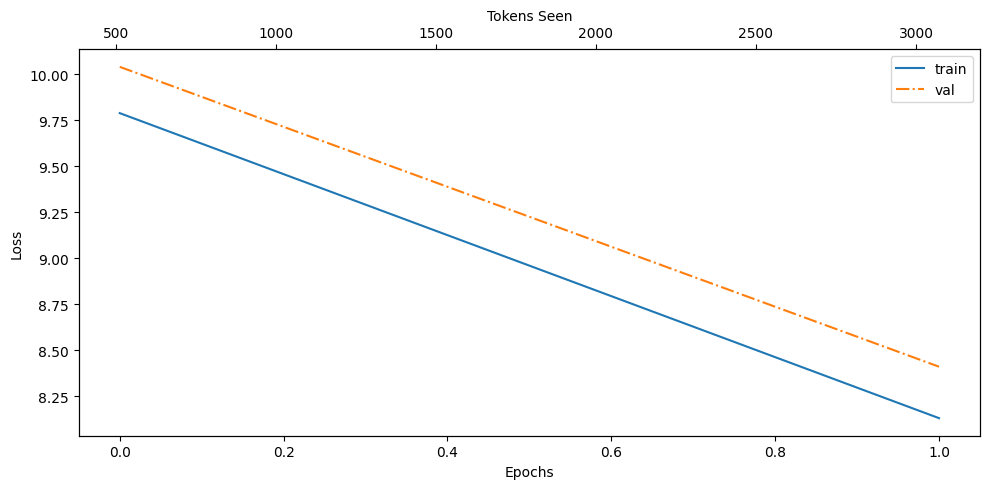

In [23]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(epochs_seen, train_losses, label="train")
    ax.plot(epochs_seen, val_losses, linestyle='-.', label="val")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

    ax1 = ax.twiny()
    ax1.plot(tokens_seen, train_losses, alpha=0)
    ax1.set_xlabel("Tokens Seen")

    fig.tight_layout()
    plt.show()

epoch_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epoch_tensor, track_token_seen, train_losses, val_losses)

## 5.3 控制随机性的解码策略


主要介绍两个函数：`temperature scaling` 和 `top-k sampling`

首先需要将模型转到cpu上，因为较小的模型在推理时不需要gpu

In [24]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768

### 5.3.1 Temperature scaling


一种添加概率选择过程到向下一代标记生成任务的技术。</br>
在前面的章节中，`generate_text_simple` 函数使用 `torch.argmax` 取最大概率，这一行为被称为贪婪解码 greedy decode。</br>
为了使输出更加多样化，我们使用 **`从概率分布进行采样`** 来替换掉`argmax`

In [25]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(">> inverse vocab (argmax): ", inverse_vocab[next_token_id])

next_token_id = torch.multinomial(probas, num_samples=1).item()
print(">> inverse vocab (probability distribution): ", inverse_vocab[next_token_id])

>> inverse vocab (argmax):  forward
>> inverse vocab (probability distribution):  forward


打印出来的结果都是forward。`multinomial`是根据概率分数的比例来对下一个标记进行采样。因此在这里，forward仍然是最大的概率分数。在执行多次后我们统计一下。

In [26]:
def print_sampled_tokens(probas):
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))  
    for i, freq in enumerate(sampled_ids):
        print(f">> sampled {freq} times: {inverse_vocab[i]}")

print_sampled_tokens(probas)

>> sampled 80 times: closer
>> sampled 1 times: every
>> sampled 0 times: effort
>> sampled 579 times: forward
>> sampled 1 times: inches
>> sampled 0 times: moves
>> sampled 0 times: pizza
>> sampled 336 times: toward
>> sampled 3 times: you


可以看出，与argmax不同，大部分情况下，会选择`forward`但是也有其他的可能。</br>
我们可以通过一个叫做`temperature scaling`的概念来控制分布和选择过程。`temperature scaling`只是一个大于0的树。

In [27]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

temperature大于1会得到更加均匀的分布，小于1则会得到更尖锐的分布

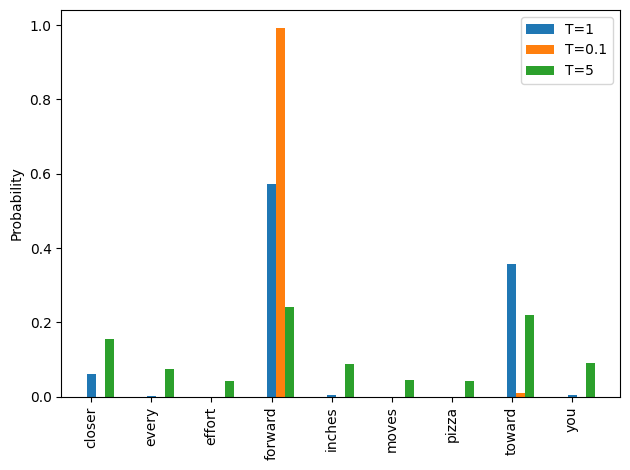

In [28]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, t) for t in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots()
for i, T in enumerate(temperatures):
    ax.bar(x + i * bar_width, scaled_probas[i], width=bar_width, label=f"T={T}")

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(list(vocab.keys()), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### 5.3.2 Top-k sampling


上一节的温度采样和温度尺度可能会生成错误的结果，为了使结果更加准确，我们采用Tok-k采样。当结合概率采样和温度尺度时，可以提高文本生成结果。

在top-k抽样中，我们可以将采样的标记限制在最可能的top-k标记中，并通过屏蔽其概率分数，从选择过程中排除所有其他标记，如下图所示。

![1718954311719](../image/从零开始构建LLM/1718954311719.png)

In [29]:
# >> top k and position
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print(">> top logits: ", top_logits)
print(">> top positions: ", top_pos)

# >> mask logits
new_logits = torch.where(condition=next_token_logits < top_logits[-1],
                         input=torch.tensor(float('-inf')),
                         other=next_token_logits)
print(">> new logits: ", new_logits)

# >> topk probas
topk_probas = torch.softmax(new_logits, dim=0)
print(">> topk probas: ", topk_probas)

>> top logits:  tensor([6.7500, 6.2800, 4.5100])
>> top positions:  tensor([3, 7, 0])
>> new logits:  tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
>> topk probas:  tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


在此引入温度尺度

### 5.3.3 修改文本生成函数

In [30]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        # >> context
        idx_cond = idx if idx.size(0) <= context_size else idx[-context_size:]

        # >> logits
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # last

        # >> topk
        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]  # min value
            # mask logits
            logits = torch.where(condition=logits < min_val, input=torch.tensor(float('-inf')), other=logits)
        
        # >> temperature
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [31]:
token_ids = generate(model=model, idx=text_to_token_ids("Every effort moves you", tokenizer), 
                     max_new_tokens=15, 
                     context_size=GPT_CONFIG_124M["context_length"],
                     top_k=25,
                     temperature=1.4)
print(">> generated text: ", token_ids_to_text(token_ids, tokenizer))

>> generated text:  Every effort moves you I
 a of to with. the"-- of the a to his


## 5.4 在PyTorch中加载和保存模型权重

除了原始的保存模型之外，可以保存优化器等参数

> model.eval()作用：**禁用dropout**

AdamW使用历史数据来动态调整每个模型参数的学习速率。如果没有它，优化器就会重置，模型可能会学习次优，甚至不能正确收敛，这意味着它将失去生成连贯文本的能力。使用torch.save，我们可以保存模型和优化器的state_dict的内容如下：

In [32]:
model_path = os.path.join("..", "models", "custom", "model_and_optimizer.pth")

# save model and optimizer
torch.save({
    "model_states_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, model_path)

# load model and optimizer
checkpoint = torch.load(model_path)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_states_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768

## 5.5 从OpenAI中加载预训练模型

In [ ]:
# gpt_download.py

import os
import urllib.request

# import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


"""
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file
"""


def download_file(url, destination):
    # Send a GET request to download the file
    with urllib.request.urlopen(url) as response:
        # Get the total file size from headers, defaulting to 0 if not present
        file_size = int(response.headers.get("Content-Length", 0))

        # Check if file exists and has the same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return

        # Define the block size for reading the file
        block_size = 1024  # 1 Kilobyte

        # Initialize the progress bar with total file size
        progress_bar_description = os.path.basename(url)  # Extract filename from URL
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
            # Open the destination file in binary write mode
            with open(destination, "wb") as file:
                # Read the file in chunks and write to destination
                while True:
                    chunk = response.read(block_size)
                    if not chunk:
                        break
                    file.write(chunk)
                    progress_bar.update(len(chunk))  # Update progress bar


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [ ]:
settings, params = download_and_load_gpt2("124M", "models")
print("settings: ", settings)
print("params: ", params)

> 上述代码出错，分析原因为torch、tensorflow的部分不兼容， 没有找到好的解决方案，因此使用其他方法来解决<br/>

安装transformers包：`pip install transformers`

方案一：使用包从huggingface上下载，可以直接使用，这一部分网上代码很多

> 可能也会报错，出现网络错误，无法连接等问题（比较看脸）。

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline, set_seed

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

方案二：手动从[huggingface的gpt2模型](https://huggingface.co/openai-community/gpt2/tree/main)中下载，其中，下载示例脚本在[download_huggingface_model.ipynb](./scripts/download_huggingface_model.ipynb)

In [33]:
from transformers import GPT2Model, GPT2Tokenizer, AutoConfig

config = AutoConfig.from_pretrained("../models/gpt2/config.json")
tokenizer = GPT2Tokenizer.from_pretrained("../models/gpt2/")
model = GPT2Model.from_pretrained("../models/gpt2/")

print(">> config:", config)

>> config: GPT2Config {
  "_name_or_path": "../models/gpt2/config.json",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.36.1",
  "use_cache": true,
  "vocab_size": 50257
}



In [34]:
print(">> tokenizer:", tokenizer)

>> tokenizer: GPT2Tokenizer(name_or_path='../models/gpt2/', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}


In [35]:
print(">> model:", model)

>> model: GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


![1719213912457](../image/从零开始构建LLM/1719213912457.png)

In [36]:
# model's block weight
model.wte.weight

Parameter containing:
tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
       requires_grad=True)

接下来将模型参数加载至我们自己的GPTModel中，首先选用最小的模型

In [37]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()
gpt

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layer): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, 

加载函数如下，其中，转置操作应当一致，无法修改

In [38]:
def load_weights_into_gpt(gpt, model):

    def assign(left, right):
        if left.shape != right.shape:
            raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
        with torch.no_grad():
            left.copy_(torch.tensor(right))
    
    assign(gpt.tok_emb.weight, model.wte.weight)
    assign(gpt.pos_emb.weight, model.wpe.weight)

    for b in range(len(model.h)):
        q_w, k_w, v_w = np.split(
            model.h[b].attn.c_attn.weight, 3, axis=-1
        )

        assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            model.h[b].attn.c_attn.bias, 3, axis=-1
        )

        assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        assign(gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        assign(gpt.trf_blocks[b].att.out_proj.weight, model.h[b].attn.c_proj.weight.T)
        assign(gpt.trf_blocks[b].att.out_proj.bias, model.h[b].attn.c_proj.bias)

        assign(gpt.trf_blocks[b].ff.layer[0].weight, model.h[b].mlp.c_fc.weight.T)
        assign(gpt.trf_blocks[b].ff.layer[0].bias, model.h[b].mlp.c_fc.bias)
        assign(gpt.trf_blocks[b].ff.layer[2].weight, model.h[b].mlp.c_proj.weight.T)
        assign(gpt.trf_blocks[b].ff.layer[2].bias, model.h[b].mlp.c_proj.bias)

        assign(gpt.trf_blocks[b].norm1.scale, model.h[b].ln_1.weight)
        assign(gpt.trf_blocks[b].norm1.shift, model.h[b].ln_1.bias)
        assign(gpt.trf_blocks[b].norm2.scale, model.h[b].ln_2.weight)
        assign(gpt.trf_blocks[b].norm2.shift, model.h[b].ln_2.bias)
    
    assign(gpt.final_norm.scale, model.ln_f.weight)
    assign(gpt.final_norm.shift, model.ln_f.bias)
    assign(gpt.out_head.weight, model.wte.weight)

In [41]:
load_weights_into_gpt(gpt, model)

C:\Users\xuexiaolei\AppData\Local\Temp\ipykernel_36220\2137781906.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  left.copy_(torch.tensor(right))


验证模型生成效果

In [42]:
tokenids = generate(gpt, idx=text_to_token_ids("Once upon a time", tokenizer).to(device),
         max_new_tokens=50, context_size=NEW_CONFIG['context_length'],
         top_k=50, temperature=1.5)
print(">> generated text By MyGPT: \n", token_ids_to_text(tokenids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


>> generated text By MyGPT: 
 Once upon a time of deep crisis, in particular those at their disposal in these perilous situations — as far back as the days of Napoleon himself—we will see how they came to this state of affairs, and how they came to collapse quickly. This is the state of


In [43]:
def generate_by_gpt2(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        # >> context
        idx_cond = idx if idx.size(0) <= context_size else idx[-context_size:]

        # >> logits
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits.last_hidden_state[:, -1, :]  # last

        # >> topk
        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]  # min value
            # mask logits
            logits = torch.where(condition=logits < min_val, input=torch.tensor(float('-inf')), other=logits)
        
        # >> temperature
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

model.eval()

generated_ids = generate_by_gpt2(model, idx=tokenizer.encode("Once upon a time", return_tensors='pt'),
         max_new_tokens=25, context_size=NEW_CONFIG['context_length'],
         top_k=50, temperature=1.5)
# 解码生成的文本
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print(generated_text)

Once upon a timeageageageageageageageageageageageageageageageageageageageageageageageageage


: 

> GPT2Model 与 GPTLMHeadModel不一样， GPT2Model主要用于获取模型的隐藏状态，而GPTLMHeadModel集成了GPT2Model并添加了语言建模的头部，使其能够进行文本生成。

In [44]:
from transformers import GPT2LMHeadModel

GPT2LMHeadModel____ = GPT2LMHeadModel.from_pretrained('../models/gpt2')

text = "Once upon a time"
input_ids = tokenizer.encode(text, return_tensors='pt')

output = model.generate(input_ids, max_length=50, num_return_sequences=1)

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(">> generated text: \n", generated_text)